In [1]:
# This code fits our stripped star candidates to the composite grid of models
# It uses the chi squared statistic to find the best fit model and the log likelihood to find the best fit model
# It also finds the confidence interval for the stripped star mass and the MS companion mass
# It saves the results to a csv file
# Author: Bethany Ludwig 
# Last update: 2025-02-20
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import minimize
from scipy.stats import chi2
import os
data_dir = os.getenv("DATADIR")
plt.style.use(data_dir+'bl.mplstyle')
#############
# Functions #
#############
# Chi Sq 
def chi_sq(obs_mag,obs_err,synth_mag):
    # Chi Square: Sum (Obs - Model) ^2 / error^2
    chi_df = (obs_mag - synth_mag)**2 / obs_err **2
    chi_sum = chi_df.sum(axis=1)
    return chi_sum
# MLE - Log Likelihood
def log_likelihood(obs_mag,obs_err,synth_mag):
    # ln(sigma^2)
    errs = (np.array(obs_err)**2).astype(float)
    err_sum = np.log(errs).sum()
    # Chi Square: Sum (Obs - Model) ^2 / error^2
    chi_sum = chi_sq(obs_mag,obs_err,synth_mag)
    log_likelihood = -1.0 * (chi_sum + err_sum)
    return log_likelihood


def fit(row,synth_photom):
    # Column names
    sums_mag_cols = ['uvw2','uvm2','uvw1','U','B','V','I']
    sums_err_cols = ['uvw2_err','uvm2_err','uvw1_err','e_U','e_B','e_V','e_I']
    
    # Get columns if both the mag and the err are finite 
    mag_cols = []
    err_cols = []
    for mag,err in zip(sums_mag_cols,sums_err_cols):
        if np.isfinite(row[mag]) & np.isfinite(row[err]):
            mag_cols.append(mag)
            err_cols.append(err)

    # SED and ERR
    obs_mag = np.array(row.loc[mag_cols].values)
    obs_err = np.array(row.loc[err_cols].values)

    # Get synthetic photometry based on what isn't a nan in the observed
    synth_mag_cols = [sums_col.split('_')[0].upper() for sums_col in mag_cols]
    synth_mag = synth_photom[synth_mag_cols].values

    # Number of photometry datapoints minus number of model parameters 
    # (3, 1 from stripped star model, 1 from MS model, 1 from extinction)
    dof = len(obs_mag) - 3
 
    # Chi Squared Statistic
    chi_sum = chi_sq(obs_mag,obs_err,synth_mag)

    # Log Likelihood
    log_likelihood_sum = log_likelihood(obs_mag,obs_err,synth_mag)

    # Where is chi minimized and what is the chi value
    min_reduced_chi_index = np.argmin(chi_sum)
    min_reduced_chi_value = chi_sum[min_reduced_chi_index]

    # Maximize Log Likelihood
    max_log_likelihood_index = np.argmax(log_likelihood_sum)
    max_log_likelihood_value = log_likelihood_sum[max_log_likelihood_index]

    
    return chi_sum, min_reduced_chi_index, min_reduced_chi_value, max_log_likelihood_index, max_log_likelihood_value, dof

#########
# Model #
#########
synth_smc = pd.read_csv(data_dir+'0_SUMS_Catalogs/CompositeGrid/smc_composite_photometry_extincted.csv')
synth_lmc = pd.read_csv(data_dir+'0_SUMS_Catalogs/CompositeGrid/lmc_composite_photometry_extincted.csv')

############
# Observed #
############
df = pd.read_csv(data_dir+'0_SUMS_Catalogs/CandidateCatalog/3_stripped_star_candidates.csv')
print('Init size ',df.shape)
obs_smc = df[df['galaxy'] == 'smc'].reset_index(drop=True)
obs_lmc = df[df['galaxy'] == 'lmc'].reset_index(drop=True)

###########
# Fitting #
###########
run = True
if run: 
    for df,sf in zip([obs_smc,obs_lmc],[synth_smc,synth_lmc]):
        names = sf.columns
        for ind,row in df.iterrows():
            chi_sum, chi_index, chi_value, log_likelihood_index, log_likelihood_value, dof = fit(row,sf)
            # Add info about fit 
            df.loc[ind,'fit_chi_sq_index'] = chi_index
            df.loc[ind,'fit_chi_sq'] = chi_value
            df.loc[ind,'fit_log_likelihood_index'] = log_likelihood_index
            df.loc[ind,'fit_log_likelihood'] = log_likelihood_value
            df.loc[ind,'fit_dof'] = dof
            # Add the best fit model to the dataframe
            for col in names:
                df.loc[ind,f'fit_{col}'] = sf.loc[chi_index,col]
            # Add max and min values for M_companion and M_stripped_star within some confidence interval
            floor_chi =  chi_value # min chi value we get 
            q_sigma = 0.6827 # 1sigma confidence interval
            confidence_1 = floor_chi + chi2.ppf(q_sigma, dof)
            if np.isfinite(confidence_1):
                m_strips = sf.loc[chi_sum < confidence_1,'M_strip']
                m_comps = sf.loc[chi_sum < confidence_1,'M_MS']
            else:
                m_strips = np.array([np.nan])
                m_comps = np.array([np.nan])
            df.loc[ind,'fit_M_strip_min'] = m_strips.min()
            df.loc[ind,'fit_M_strip_max'] = m_strips.max()
            df.loc[ind,'fit_M_MS_min'] = m_comps.min()
            df.loc[ind,'fit_M_MS_max'] = m_comps.max()

    # Recombine 
    results = pd.concat([obs_smc,obs_lmc]).reset_index(drop=True)
    # Save 
    results.to_csv(data_dir+'0_SUMS_Catalogs/CandidateCatalog/4_stripped_star_candidates_fit.csv',index=False)

else:
    results = pd.read_csv(data_dir+'0_SUMS_Catalogs/CandidateCatalog/4_stripped_star_candidates_fit.csv')

Init size  (820, 145)


[(-2.25, 1.5), (-2.25, 1.5)]

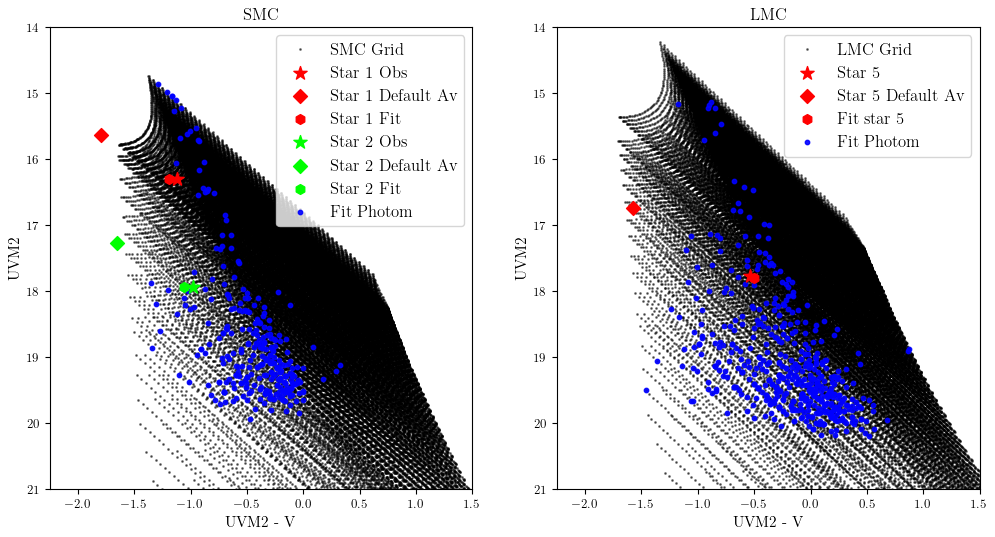

In [2]:
# Where are they photometrically compared to our grid 
star1 = obs_smc.loc[obs_smc.discovery_name == 'Star_1']
star2 = obs_smc.loc[obs_smc.discovery_name == 'Star_2']
star5 = obs_lmc.loc[obs_lmc.discovery_name == 'Star_5']

f, axes = plt.subplots(1,2, figsize=(12,6))
z1 = 100
alpha = 0.4
axes[0].scatter(synth_smc.UVM2 - synth_smc.V, synth_smc.UVM2, s=1, c='k', alpha=0.5,label='SMC Grid')
for star,c,l in zip([star1,star2],['r','lime'],['Star 1','Star 2']):
    axes[0].scatter(star['uvm2'] - star['V'], star['uvm2'], s=100, c=c,label=f'{l} Obs',alpha=1,marker='*',zorder=z1)
    axes[0].scatter(star['uvm2_dered'] - star['V'], star['uvm2_dered'], s=50, c=c,label=f'{l} Default Av',alpha=1,marker='D',zorder=z1)
    axes[0].scatter(star['fit_UVM2'] - star['fit_V'], star['fit_UVM2'], s=50, c=c,label=f'{l} Fit',alpha=1,marker='h',zorder=z1)
axes[0].scatter(obs_smc['fit_UVM2'] - obs_smc['fit_V'], obs_smc['fit_UVM2'], s=10, c='b',label='Fit Photom',alpha=0.9)
axes[0].set_xlabel('UVM2 - V')
axes[0].set_ylabel('UVM2')
axes[0].set_title('SMC')
axes[0].invert_yaxis()

axes[1].scatter(synth_lmc.UVM2 - synth_lmc.V, synth_lmc.UVM2, s=1, c='k', alpha=0.5,label='LMC Grid')
axes[1].scatter(star5['uvm2'] - star5['V'], star5['uvm2'], s=100, c='r',label='Star 5',alpha=1,marker='*',zorder=z1)
axes[1].scatter(star5['uvm2_dered'] - star5['V'], star5['uvm2_dered'], s=50, c='r',label='Star 5 Default Av',alpha=1,marker='D',zorder=z1)
axes[1].scatter(star5['fit_UVM2'] - star5['fit_V'], star5['fit_UVM2'], s=50, c='r',label='Fit star 5',alpha=1,marker='h',zorder=z1)
axes[1].scatter(obs_lmc['fit_UVM2'] - obs_lmc['fit_V'], obs_lmc['fit_UVM2'], s=10, c='b',label='Fit Photom',alpha=0.9)
axes[1].set_xlabel('UVM2 - V')
axes[1].set_ylabel('UVM2')
axes[1].set_title('LMC')
axes[1].invert_yaxis()
axes[0].legend(loc='upper right',fontsize=12)
axes[1].legend(loc='upper right',fontsize=12)
[ax.set_ylim(21,14) for ax in axes]
[ax.set_xlim(-2.25,1.5) for ax in axes]


19.38028820779194


Text(0, 0.5, 'Number of Candidates')

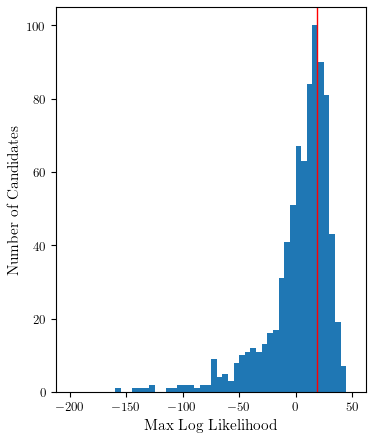

In [3]:
# Assess results - what does the log likelihood look like 
# Exponential distribution 

# What does the 70% percentile look like?
percentile = np.percentile(results.fit_log_likelihood,70)
print(percentile)
plt.figure(figsize=(4,5))
range = (-200,50)
plt.hist(results['fit_log_likelihood'],bins=50,range=range);
plt.axvline(percentile,color='red',label='70%')
plt.xlabel('Max Log Likelihood')
plt.ylabel('Number of Candidates')

6.247218009884164


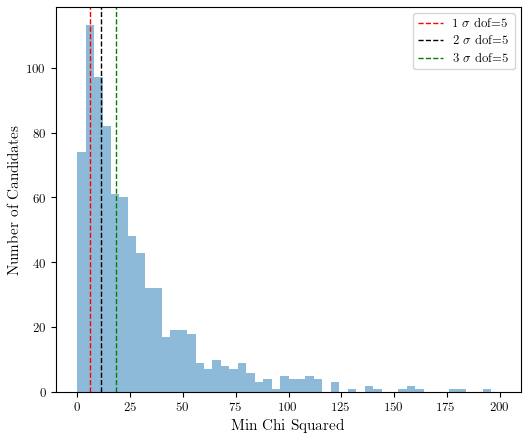

In [4]:
# What about chi squared?
plt.figure(figsize=(6,5))
range = (0,200)
q_1sigma = 0.6827
q_2sigma = 0.95
q_3sigma = 0.997
floor_chi = results.fit_chi_sq.min()
sigma_1 = floor_chi + chi2.ppf(q_1sigma, 7-2)
sigma_2 = floor_chi + chi2.ppf(q_2sigma, 7-2)
sigma_3 = floor_chi + chi2.ppf(q_3sigma, 7-2)
print(sigma_1)

# If we use this dont use sigma language use like 68% confidence(?)
plt.hist(results['fit_chi_sq'],bins=50,range=range,alpha=0.5);
plt.axvline(sigma_1,color='red',label='1 $\\sigma$ dof=5',ls='--')
plt.axvline(sigma_2,color='k',label='2 $\\sigma$ dof=5',ls='--')
plt.axvline(sigma_3,color='green',label='3 $\\sigma$ dof=5',ls='--')
plt.xlabel('Min Chi Squared')
plt.ylabel('Number of Candidates')
plt.legend()

[None, None, None, None]

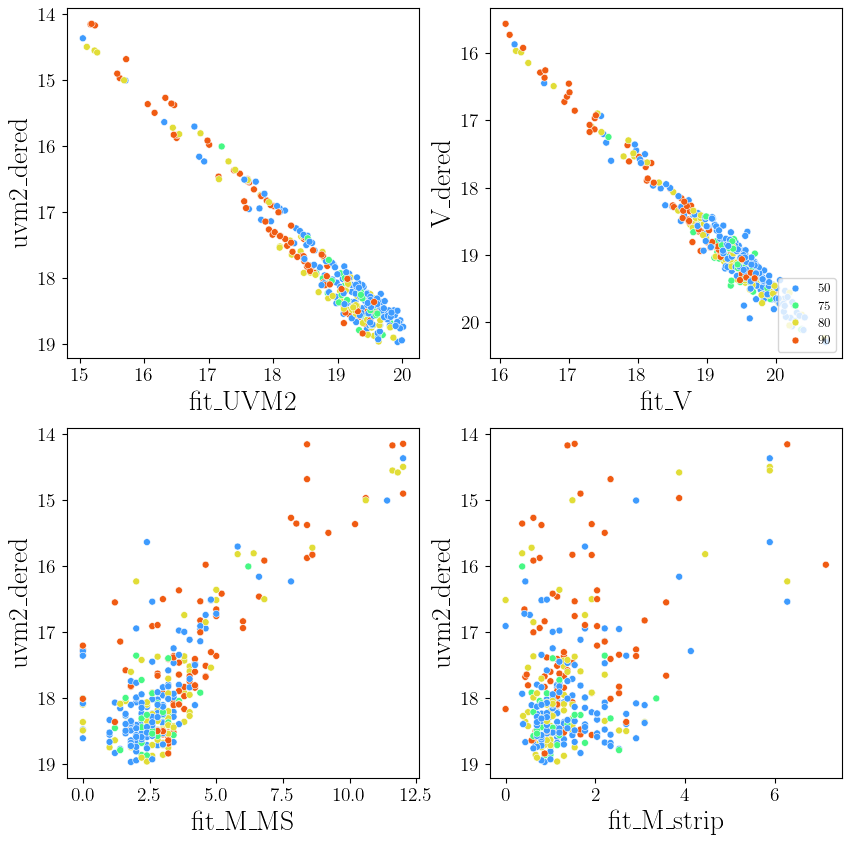

In [5]:
# What do parameters look like? 
import seaborn as sns 

cols = ['fit_UVM2','fit_V','fit_M_MS','fit_M_strip']
ycols = ['uvm2_dered','V_dered','uvm2_dered','uvm2_dered']
ycols_label = ['UVM2','V','UVM2','UVM2']

results['logp_bin'] = pd.qcut(results['fit_log_likelihood'],q=[0.5,0.75,0.8,0.9,1],labels=['50%','75%','80%','90%'])

f, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for ax,col,ycol in zip(axes,cols,ycols):
    sns.scatterplot(data=results, x=col, y=ycol, hue='logp_bin', palette='turbo',ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel(col,fontsize=20)
    ax.set_ylabel(ycol,fontsize=20)

[ax.get_legend().remove() for ax in axes]
axes[1].legend(loc="lower right")
fs = 16
ts = 14
[ax.tick_params(axis='both', which='major', labelsize=ts) for ax in axes]


2466


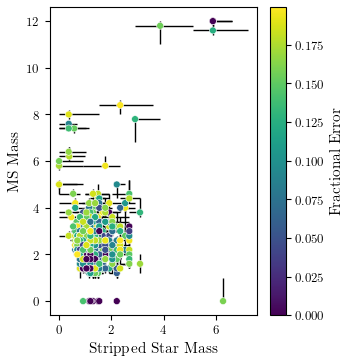

In [6]:
# Reimporting in case one of the earlier steps did a constraint I don't expect 
obs_smc = pd.read_csv(data_dir+'0_SUMS_Catalogs/CandidateCatalog/candidates_smc_fit.csv')
obs_lmc = pd.read_csv(data_dir+'0_SUMS_Catalogs/CandidateCatalog/candidates_lmc_fit.csv') 
results = pd.concat([obs_smc,obs_lmc])

# Calc frac error 
def frac_error(strip,ms,strip_width,ms_width):
    err = np.sqrt((strip_width)**2 + (ms_width)**2)
    M = strip + ms
    return err / M
strip_width = results.fit_M_strip_max - results.fit_M_strip_min
ms_width = results.fit_M_MS_max - results.fit_M_MS_min
results['fit_frac_err'] = frac_error(results.fit_M_strip,results.fit_M_MS,strip_width,ms_width)


print(results.shape[0])
# Remove if fit gave nan 
results = results.dropna(subset=['fit_log_likelihood'])
results = results.dropna(subset=['fit_M_strip_min']).reset_index(drop=True)

rows = results
# Remove if xmax - xmin  or ymax - ymin > some limit
lim = 20
xmin = rows.fit_M_strip_min
xmax = rows.fit_M_strip_max
rows = rows[xmax-xmin < lim]
ymin = rows.fit_M_MS_min
ymax = rows.fit_M_MS_max
rows = rows[ymax-ymin < lim]

# Remove if fractional error is more than X
frac_lim = 0.2 
rows = rows[rows.fit_frac_err < frac_lim].reset_index(drop=True)

x = rows.fit_M_strip
y = rows.fit_M_MS
xmin = rows.fit_M_strip_min
xmax = rows.fit_M_strip_max
ymin = rows.fit_M_MS_min
ymax = rows.fit_M_MS_max

# Make dataframe from dict
d = {'x':x,'y':y,'xmin':xmin,'Chi Squared':rows.fit_chi_sq,'Log Likelihood':rows.fit_log_likelihood,'Fractional Error':rows.fit_frac_err}
df = pd.DataFrame(data=d)

#f, axes = plt.subplots(1,2)
ax = plt.subplot()
errorbarcolor = 'k'
z1 = -1
label = 'Chi Squared'
label = 'Log Likelihood'
label= 'Fractional Error'
cmap = 'viridis'
norm = plt.Normalize(d[label].min(), d[label].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
ax.hlines(y, xmin, xmax,color=errorbarcolor,zorder=z1)
ax.vlines(x, ymin, ymax,color=errorbarcolor,zorder=z1)
sns.scatterplot(data=df, x='x', y='y', hue=label, palette=cmap,ax=ax,legend=False)
ax.set_xlabel('Stripped Star Mass')
ax.set_ylabel('MS Mass')
ax.figure.colorbar(sm, ax=ax,label=label)


Text(0, 0.5, 'Number of Candidates')

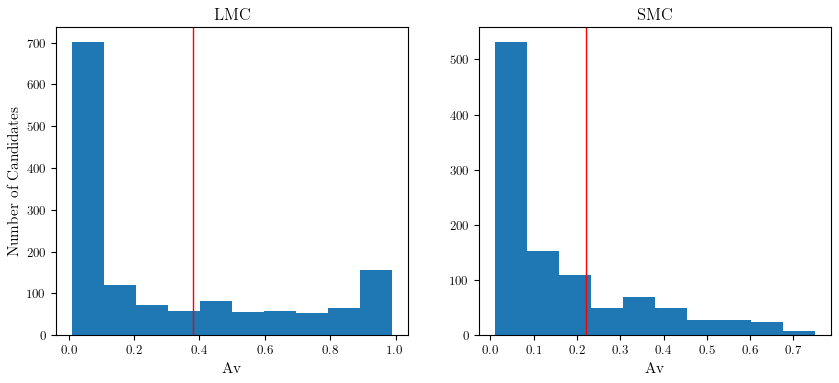

In [7]:
# Default Av 
smc_av = 0.22
lmc_av = 0.38 

av_rows = results.copy()

f, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(av_rows[av_rows.galaxy=='lmc'].fit_Av)
axes[1].hist(av_rows[av_rows.galaxy=='smc'].fit_Av)
axes[0].axvline(lmc_av,color='red',label='Default Av')
axes[1].axvline(smc_av,color='red',label='Default Av')
axes[0].set_title('LMC')
axes[1].set_title('SMC')
axes[0].set_xlabel('Av')
axes[1].set_xlabel('Av')
axes[0].set_ylabel('Number of Candidates')